In [2]:
import matplotlib.pyplot as plt
import skimage.io as io

from models.models import *
from models.UNet import UNet2D

import torch
from skimage import graph, data, io, segmentation, color, filters
from skimage.measure import regionprops
from skimage import draw
from skimage.segmentation import relabel_sequential
import numpy as np
from random import shuffle
import skimage.future.graph as graph

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def show_img(img, size=5):
    f = plt.figure(figsize=(size, size))
    plt.imshow(img)

def gray2rgb (img):
    return np.repeat (np.expand_dims (img, -1), 3, -1)
    
def gridize (img, dx, dy):

    # Custom (rgb) grid color
    grid_color = [0,255,255]
    img = np.copy (img)
    # Modify the image to include the grid
    img[:,::dy,:] = grid_color
    img[::dx,:,:] = grid_color
    return img

import colorsys

def color_generator (N):
    HSV_tuples = [(x*1.0/N, 0.5, (x%8)*0.07 + 0.5) for x in range(N)]
    RGB_tuples = list (map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))

    COLOR_LIST = [(int (rgb[0] * 255), int (rgb[1] * 255), int (rgb[2] * 255)) for rgb in RGB_tuples]
    shuffle (COLOR_LIST)
    COLOR_LIST [0] = (0, 0, 0)

    def index2rgb (index):
        return COLOR_LIST [index]
    def lbl2rgb (lbl):
        original_shape = np.squeeze (lbl).shape
        lbl = lbl.flatten ().tolist ()
        lbl = list (map (index2rgb, lbl))
        lbl = np.array (lbl).reshape (original_shape + (3,))
        return lbl
    return lbl2rgb

color_g = color_generator (3000)

In [5]:
img = io.imread ("Data/Cremi/Corrected/256/train/A/A_0.tif")
lbl = relabel_sequential (io.imread ("Data/Cremi/Corrected/256/train/B/B_0.tif")) [0] .astype (np.int32)
lbl_rgb = color_g (lbl + 1)
lbl += 1

In [6]:
over_seg = segmentation.slic(img, compactness=0.1, n_segments=2048, start_label=1)
regions = regionprops(over_seg, lbl, cache=True)

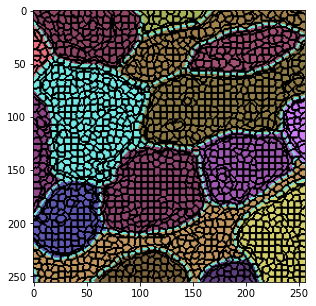

In [7]:
label_rgb = gray2rgb (img)
label_rgb = segmentation.mark_boundaries(lbl_rgb * 1.0 / 256, over_seg, (0,0,0), mode="thin")
show_img (label_rgb)
# show_img (color_g (over_seg))
# print (np.max (over_seg), np.min (over_seg))


In [7]:
INP_SHAPE = (1,) + img.shape
FEATS = [32, 64, 128, 256, 512]
model = UNet2D (INP_SHAPE [0], FEATS, 64)

In [8]:
img_t = torch.tensor (img, dtype=torch.float32) [None][None]
out = model (img_t)

In [9]:
def display_bbox (img, g):
    img = np.copy (img)
    for node in g.nodes:
        if np.random.rand () < 0.7:
            continue
        node = g.nodes [node]
        r0, c0, r1, c1 = node ["bbox"]
        r1 = min (254, r1)
        c1 = min (254, c1)
        box = draw.rectangle_perimeter ((r0,c0), (r1,c1))
        img [box] = 0,1,1
    return img

0.17.2


/home/tuan/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  


(2.7666666666666666, 5.083333333333333)


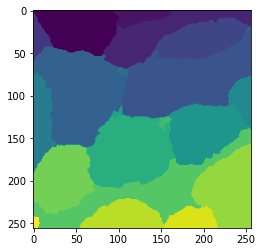

3836
0.7366881370544434
num nodes 1331
[0.33333333 1.        ] [0 2] 54 0.0


In [10]:
from skimage.measure import label, regionprops
import inspect

import skimage
print(skimage.__version__)

over_seg = segmentation.slic(img, compactness=0.1, n_segments=1200, start_label=1)
edge_map = filters.sobel(color.rgb2gray(img))
rag = graph.rag_boundary(over_seg, edge_map)

tmp = list (rag.edges)

# regions = regionprops(over_seg, lbl, extra_properties)
regions = regionprops(over_seg, lbl)
      
print (regions [0]['centroid'])

import time

curtime = time.time ()

node_colors = np.array ([0] * (np.max (over_seg) + 1))

for i, region in enumerate (regions):
    
    
    if region ['label'] != i + 1:
        print ("not match")
    
    rag.nodes[region['label']]['centroid'] = region ['centroid']
    rag.nodes[region['label']]['bbox'] = region ['bbox']
    rag.nodes[region['label']]['coords'] = region ['coords']
    rag.nodes[region['label']]['convex_image'] = region ['convex_image']
    rag.nodes[region['label']]['foreground_area'] = np.count_nonzero (region ['image'] * (region ['intensity_image'] > 0))
    rag.nodes[region['label']]['background_area'] = np.count_nonzero (region ['image'] * (region ['intensity_image'] < 0))
    rag.nodes[region['label']]['label_image'] = region ['intensity_image']
    rag.nodes[region['label']]['labels'], rag.nodes[region['label']]['affinity'] = \
                np.unique (region ['intensity_image'] * region ['image'] * (region ['intensity_image'] > 0), return_counts=True)
#     if (len (rag.nodes[region['label']]['labels']) > 2):
#         print (region['label'])
    rag.nodes[region['label']]['affinity'] = rag.nodes[region['label']]['affinity'] / rag.nodes[region['label']]['foreground_area']
    rag.nodes[region['label']]['bg_affinity'] = rag.nodes[region['label']]['background_area'] / region ['area']
    rag.nodes[region['label']]['coords'] = region ['coords']
    rag.nodes[region['label']]['bbox'] = region ['bbox']
    node_colors [region['label']] = rag.nodes[region['label']]['labels'] [-1]

process_time = time.time () - curtime

plt.imshow (node_colors [over_seg])
plt.show ()

print (len (rag.edges))

print (process_time)
    
cnt = 0
for node in rag.nodes:
    cnt += 1
print ("num nodes", cnt)

idx = 6
# plt.imshow (rag.nodes[idx]['label_image'])
# plt.show ()
print (rag.nodes[idx]['affinity'], rag.nodes[idx]['labels'], rag.nodes[idx]['foreground_area'], rag.nodes[idx]['bg_affinity'])

# print (type (rag.edges))

In [19]:
print (len (regions))

for i in range (1, len (regions) + 1):
    if i != regions [i - 1]["label"]:
        print ("Not equal: ", i, regions [i]["label"])
        break
        

for i, region in enumerate (regions):
    if i + 1 != region ["label"]:
        print ("Not equal: ", i)
        break

1331


61 (61, 2)
(256, 256, 3)
(2, 256, 3)
(8, 8)


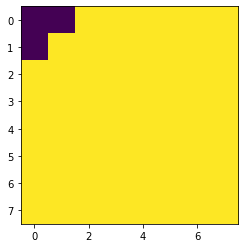

In [46]:
idx = 700
tmp_cords = rag.nodes[idx]['coords']
print (len (tmp_cords), tmp_cords.shape)
print (label_rgb.shape)
print (label_rgb [tmp_cords [0]].shape)
tmp_img = rag.nodes [idx]['convex_image']
print (tmp_img.shape)
plt.imshow (tmp_img)
plt.show ()

In [73]:
feat_map = out
print (feat_map.shape)
print (len (rag.nodes))
boxes = [torch.tensor (rag.nodes [node] ['bbox'], dtype=torch.float32) [None] for node in rag.nodes]
boxes = torch.cat (boxes, 0)

torch.Size([1, 32, 256, 256])
630


In [74]:
import torchvision.ops as ops

In [78]:
feats = ops.roi_align (feat_map, boxes=[boxes], output_size=(64, 64), aligned=True)

In [79]:
print (feats.shape)

torch.Size([630, 32, 64, 64])


/home/tuan/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  """Entry point for launching an IPython kernel.
/home/tuan/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  This is separate from the ipykernel package so we can avoid doing imports until


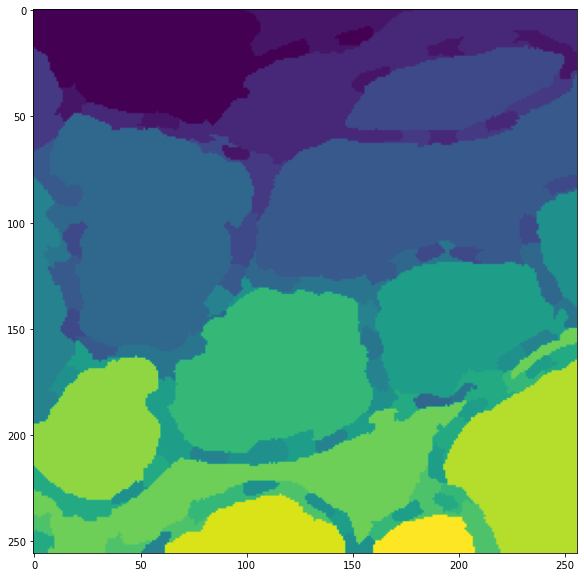

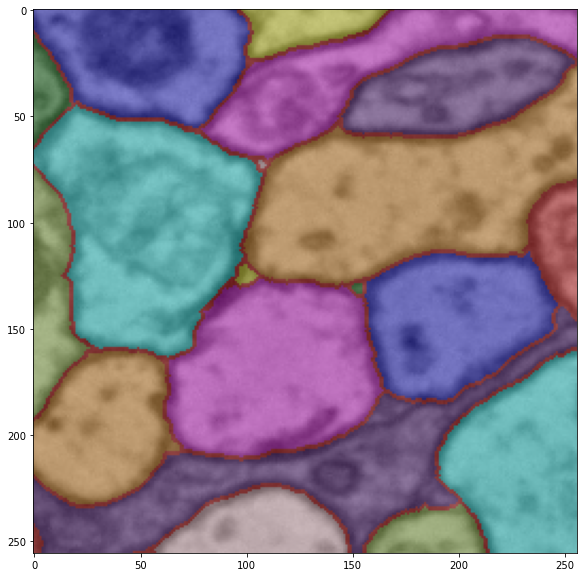

In [88]:
label_rgb = color.label2rgb(over_seg, lbl, kind='avg')
show_img (label_rgb)
label_rgb = color.label2rgb(lbl, img, kind='overlay')
show_img (label_rgb)